In [1]:
import plaidml.keras

plaidml.keras.install_backend()
import plaidml.keras.backend

In [2]:
import datetime
import tensorflow as tf
from keras import datasets, callbacks
from keras import utils
from keras import layers, optimizers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Activation,MaxPooling2D,Dropout,Flatten,Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ssl
import cv2
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
def centerCrop(image):
    dimension = image.shape
    #X < Y
    if (dimension[0] < dimension[1]):
        start = int((dimension[1] - dimension[0])/2)
        return image[0 : dimension[0], start: start + dimension[0]]
    start = int((dimension[0] - dimension[1])/2)
    return image[start : start + dimension[1], 0 : dimension[1]]

class SimpleGrapher(callbacks.Callback):    
    def __init__(self, metrics):
        self.names = []
        self.data = {}
        self.modelIndex = -1
        for metric in metrics:
            self.data[metric] = []
        
    
    def new_model(self, name):
        self.names.append(name)
        for metric in self.data:
            self.data[metric].append([])
        self.modelIndex += 1
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        for metric in self.data:            
            self.data[metric][self.modelIndex].append(logs[metric])

    def show_graph(self, metric):
        for i in range(self.modelIndex+1):
            plt.plot(np.arange(1, len(self.data[metric][i])+1), self.data[metric][i], label=self.names[i])            
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [4]:
X = np.load("X.npy").astype(np.float32)
Y = np.load("Y.npy").astype(np.float32)

In [5]:
def CNN_classification_model(numOfConvLayers, numOfDenseLayers):    
    
    input_size = X.shape[1:]
    num_classes = 3
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
    input_shape=input_size))
    model.add(Activation('relu'))
    
    for i in range(numOfConvLayers):
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Flatten())
    
    for i in range(numOfDenseLayers):
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        
    model.add(Dense(units=num_classes))
    model.add(Activation('softmax'))    
    
    opt = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
imgGen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range = [0.8, 1.2], 
    validation_split=0.10
)

# showX, showY = training.next()
# index = 3
# print(showX[index])
# plt.imshow(showX[index])
# plt.show()

In [10]:
callbacker = SimpleGrapher(["loss", "acc", "val_loss", "val_acc"])


convLayers = [2]
denseLayers = [2]
for conv in convLayers:
    for dense in denseLayers:  
        global model
        callbacker.new_model(f"{conv}-{dense}")
        print("-----NOW TRAINING-----")
        print(f"conv-{conv}-dense-{dense}-NN")
        model = CNN_classification_model(conv, dense)
        #model.summary()
        
        if (imgGen != None):
            imgGen.fit(X)
            training = imgGen.flow(X, Y, batch_size=64, subset='training')
            model.fit_generator(training, validation_data=imgGen.flow(X, Y, batch_size=64, subset='validation'),
                                 epochs=20, callbacks=[callbacker])
        else:
            model.fit(X,Y, batch_size=32, epochs=5, verbose=1, validation_split=0.10, callbacks=[callbacker])

-----NOW TRAINING-----
conv-2-dense-2-NN
Epoch 1/20
146/146 [==============================] - 65s 445ms/step - loss: 0.8142 - acc: 0.6244 - val_loss: 0.6625 - val_acc: 0.6696
Epoch 2/20
146/146 [==============================] - 29s 196ms/step - loss: 0.5970 - acc: 0.7491 - val_loss: 0.4968 - val_acc: 0.7917
Epoch 3/20
146/146 [==============================] - 29s 196ms/step - loss: 0.4946 - acc: 0.7992 - val_loss: 0.4248 - val_acc: 0.8266
Epoch 4/20
146/146 [==============================] - 29s 196ms/step - loss: 0.4537 - acc: 0.8164 - val_loss: 0.4702 - val_acc: 0.8052
Epoch 5/20
146/146 [==============================] - 29s 196ms/step - loss: 0.4311 - acc: 0.8328 - val_loss: 0.3623 - val_acc: 0.8672
Epoch 6/20
146/146 [==============================] - 29s 195ms/step - loss: 0.3661 - acc: 0.8593 - val_loss: 0.3430 - val_acc: 0.8653
Epoch 7/20
146/146 [==============================] - 29s 195ms/step - loss: 0.3974 - acc: 0.8406 - val_loss: 0.3241 - val_acc: 0.8566
Epoch 8/20
146

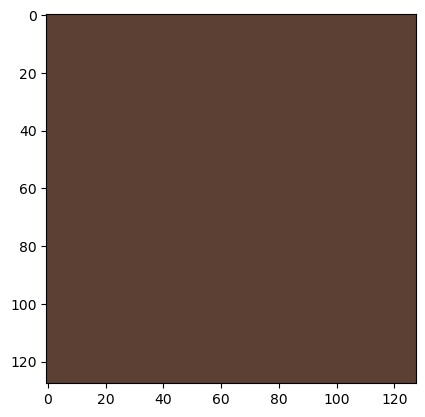

'other'

In [28]:
imgSize = 128
colorConverter = cv2.COLOR_BGR2RGB

imgTest = cv2.imread("images\\brown.png")
imgTest = centerCrop(imgTest)
imgTest = cv2.resize(imgTest, (imgSize, imgSize))
imgTest = cv2.cvtColor(imgTest, colorConverter)

#imgTest = X[13] * 255.0
plt.imshow(imgTest)
plt.show()
imgTest = np.array(imgTest).reshape(1, imgSize, imgSize, 3)
imgTest = imgTest/255.0

label = ["donut", "cap", "other"]

#print(model.predict(imgTest))
label[np.argmax(model.predict(imgTest))]

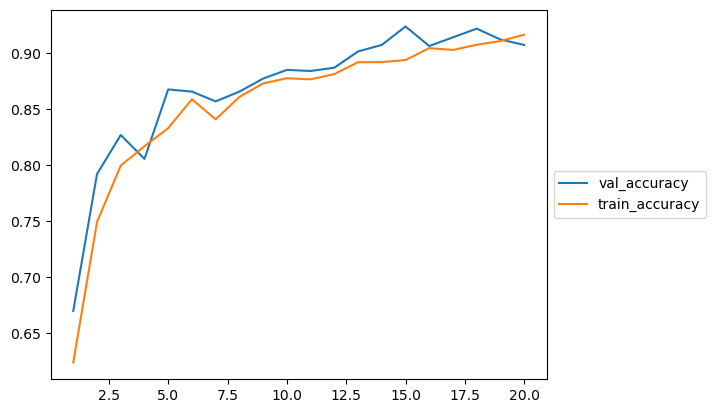

In [31]:
#callbacker.show_graph("val_acc")

for i in range(callbacker.modelIndex+1):
    plt.plot(np.arange(1, len(callbacker.data["val_acc"][i])+1), callbacker.data["val_acc"][i], label="val_accuracy")
for i in range(callbacker.modelIndex+1):
    plt.plot(np.arange(1, len(callbacker.data["acc"][i])+1), callbacker.data["acc"][i], label="train_accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [29]:
model.save("models/ThisOneIsOk6.h5")